## "Симуляция Монте-Карло"

In [5]:
# Импорт библиотек

import pandahouse
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import norm, ttest_ind
from tqdm import tqdm  # для отслеживания прогресса

In [2]:
# Подключение к ClickHouse

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '*****',
    'user': 'student',
    'database': 'simulator_20250820'
}

In [3]:
# Достанем распределение views за неделю

q = """
select views, count(user_id) as users
from (select  
    user_id,
    sum(action = 'view') as views
FROM simulator_20250820.feed_actions 
where toDate(time) between '2025-07-26' and '2025-08-01'
group by user_id
)
group by views
order by views
"""


views_distribution = pandahouse.read_clickhouse(q, connection=connection)
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
views_distribution.sort_values(by = 'p', ascending = False)

,views,users,p
15,16,545,0.012977
14,15,537,0.012787
13,14,500,0.011906
34,35,485,0.011548
29,30,469,0.011167
...,...,...,...
280,287,1,0.000024
278,285,1,0.000024
276,280,1,0.000024
1,2,1,0.000024


<Axes: ylabel='Count'>

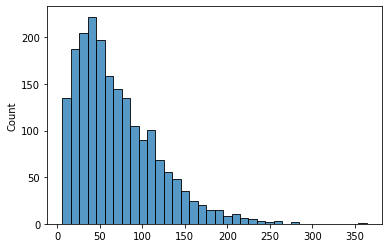

In [6]:
# построим гистограмму просмотров

views_distr = stats.rv_discrete(name='views_distr', 
                                values=(views_distribution['views'], 
                                        views_distribution['p']))
sns.histplot(views_distr.rvs(size=2000))

Видна явная асимметрия - и если присмотреться, то можно даже заметить небольшую двухгорбость.

In [7]:
# Достанем распределение CTR за неделю

q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20250820.feed_actions
where dt between '2025-07-26' and '2025-08-01'
group by dt, user_id
)
group by ctr
"""


ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.sort_values(by = 'p', ascending = False)

,ctr,users,p
17,0.20,4993,0.058658
33,0.16,4233,0.049729
50,0.25,4216,0.049529
6,0.18,4213,0.049494
72,0.21,3957,0.046487
...,...,...,...
12,0.81,2,0.000023
73,0.83,1,0.000012
20,0.73,1,0.000012
51,1.00,1,0.000012


In [8]:
# Посчитаем количество пользователей в эксперименте

total_users = views_distribution.users.sum()
group_size = total_users // 2  # Размер каждой группы (50/50)

print(f"Количество пользователей: {total_users}")
print(f"Размер выборки: {group_size}")

Количество пользователей: 41997
Размер выборки: 20998


In [9]:
# Посмотрим число пользователей за неделю (время проведения AA-теста)

q = """
SELECT  
    count(distinct(user_id)) 
FROM simulator_20250820.feed_actions
WHERE toDate(time) between '2025-07-26' and '2025-08-01'
"""

num_users = pandahouse.read_clickhouse(q, connection=connection)

In [10]:
num_users

,uniqExact(user_id)
0,41997


In [11]:
# Подготовка массивов для сэмплирования
views_values = views_distribution['views'].values
views_probs = views_distribution['p'].values

ctr_values = ctr_distribution['ctr'].values
ctr_probs = ctr_distribution['p'].values

In [12]:
# Создаём генератор псевдослучайных чисел

rng = np.random.default_rng()

### 1
К нам пришли наши коллеги из ML-отдела и рассказали, что планируют выкатывать новый алгоритм, рекомендующий нашим пользователям интересные посты. После обсуждений того, как он это делает, вы пришли к следующему пониманию:  
- алгоритм добавляет пользователям 1-2 просмотра;  
- вероятность того, что он сработает, составляет 90%;  
- если у пользователя меньше 50 просмотров, то алгоритм не сработает.  

Предполагается, что увеличение числа просмотров приведёт и к увеличению лайков на пользователя.  
Сможем ли мы обнаружить различия в среднем количестве лайков на пользователя?  
Чтобы ответить на этот вопрос, давайте проведём симуляцию Монте-Карло.

In [13]:
# Симуляция Монте-Карло

n_simulations = 20000  # количество симуляций
group_size = 20998  # размер выборки

p_values_1 = []   # результаты тестов

for _ in tqdm(range(n_simulations)):
    # Симуляция просмотров
    group_A_views = rng.choice(views_values, size=group_size, replace=True, p=views_probs).astype(np.int64)
    group_B_views = rng.choice(views_values, size=group_size, replace=True, p=views_probs).astype(np.int64)
    group_B_views_after = (
        group_B_views
        + (rng.binomial(n=1, p=0.9, size=group_size)           # вероятность того, что он сработает, составляет 90%
           * (1 + rng.binomial(n=1, p=0.5, size=group_size))   # алгоритм добавляет пользователям 1-2 просмотра
           *  (group_B_views >= 50))                           # если у пользователя меньше 50 просмотров, то алгоритм не сработает
    )
    # Симуляция CTR
    group_A_ctr = rng.choice(ctr_values, size=group_size, replace=True, p=ctr_probs)
    group_B_ctr = rng.choice(ctr_values, size=group_size, replace=True, p=ctr_probs)

    # Симуляция лайков как биномиальное распределение на основе просмотров и CTR
    group_A_likes = rng.binomial(n=group_A_views, p=group_A_ctr)
    group_B_likes = rng.binomial(n=group_B_views_after, p=group_B_ctr)

    p_value = stats.ttest_ind(group_A_likes, group_B_likes, equal_var=False).pvalue
    p_values_1.append(p_value)

100%|██████████| 20000/20000 [05:13<00:00, 63.75it/s]


In [14]:
# Расчет мощности теста
# уровень значимости alpha = 0.05

power_1 = round(np.mean(np.array(p_values_1) < 0.05) * 100, 1)
print(f"Мощность теста: {power_1}")

Мощность теста: 25.9


Мощность очень маленькая.

### 2
К нам снова пришли коллеги из ML-отдела с радостной новостью: они улучшили качество алгоритма. Теперь он срабатывает на пользователях с числом просмотров от 30 и выше. Подкорректируем симуляцию.

In [15]:
# Симуляция Монте-Карло на пользователях с числом просмотров от 30 и выше

n_simulations = 20000  # количество симуляций
group_size = 20998  # размер выборки

p_values_2 = []   # результаты тестов

for _ in tqdm(range(n_simulations)):
    # Симуляция просмотров
    group_A_views = rng.choice(views_values, size=group_size, replace=True, p=views_probs).astype(np.int64)
    group_B_views = rng.choice(views_values, size=group_size, replace=True, p=views_probs).astype(np.int64)
    group_B_views_after = (
        group_B_views
        + (rng.binomial(n=1, p=0.9, size=group_size)           # вероятность того, что он сработает, составляет 90%
           * (1 + rng.binomial(n=1, p=0.5, size=group_size))   # алгоритм добавляет пользователям 1-2 просмотра
           *  (group_B_views >= 30))                           # если у пользователя меньше 30 просмотров, то алгоритм не сработает
    )
    # Симуляция CTR
    group_A_ctr = rng.choice(ctr_values, size=group_size, replace=True, p=ctr_probs)
    group_B_ctr = rng.choice(ctr_values, size=group_size, replace=True, p=ctr_probs)

    # Симуляция лайков как биномиальное распределение на основе просмотров и CTR
    group_A_likes = rng.binomial(n=group_A_views, p=group_A_ctr)
    group_B_likes = rng.binomial(n=group_B_views_after, p=group_B_ctr)

    p_value = stats.ttest_ind(group_A_likes, group_B_likes, equal_var=False).pvalue
    p_values_2.append(p_value)

100%|██████████| 20000/20000 [05:14<00:00, 63.59it/s]


In [16]:
# Расчет мощности теста
# уровень значимости alpha = 0.05

power_2 = round(np.mean(np.array(p_values_2) < 0.05) * 100, 1)
print(f"Мощность теста: {power_2}")

Мощность теста: 41.7


Теперь у нас мощность где-то около 41.7% - то есть мы выиграли где-то 16% дополнительной мощности. Это всё ещё очень мало.

### 3
Теперь нас пришло радовать начальство: нам утвердили длительность эксперимента длиной в 2 недели. Теперь допустим, что в эти две недели к нам придёт столько же пользователей, сколько пришло суммарно за период АА-теста и АБ-теста.
Подкорректируем размер группы соответствующим образом.

In [17]:
# Посмотрим число пользователей за 2 недели (время проведения AA и AB теста)

q = """
SELECT  
    count(distinct(user_id)) 
FROM simulator_20250820.feed_actions
WHERE toDate(time) between '2025-07-26' and '2025-08-08'
"""

num_users_1 = pandahouse.read_clickhouse(q, connection=connection)

In [18]:
num_users_1//2

,uniqExact(user_id)
0,30591


In [19]:
# Симуляция Монте-Карло на пользователях с числом просмотров от 30 и выше

n_simulations = 20000  # количество симуляций
group_size = 30591  # размер выборки

p_values_3 = []   # результаты тестов

for _ in tqdm(range(n_simulations)):
    # Симуляция просмотров
    group_A_views = rng.choice(views_values, size=group_size, replace=True, p=views_probs).astype(np.int64)
    group_B_views = rng.choice(views_values, size=group_size, replace=True, p=views_probs).astype(np.int64)
    group_B_views_after = (
        group_B_views
        + (rng.binomial(n=1, p=0.9, size=group_size)           # вероятность того, что он сработает, составляет 90%
           * (1 + rng.binomial(n=1, p=0.5, size=group_size))   # алгоритм добавляет пользователям 1-2 просмотра
           *  (group_B_views >= 30))                           # если у пользователя меньше 30 просмотров, то алгоритм не сработает
    )
    # Симуляция CTR
    group_A_ctr = rng.choice(ctr_values, size=group_size, replace=True, p=ctr_probs)
    group_B_ctr = rng.choice(ctr_values, size=group_size, replace=True, p=ctr_probs)

    # Симуляция лайков как биномиальное распределение на основе просмотров и CTR
    group_A_likes = rng.binomial(n=group_A_views, p=group_A_ctr)
    group_B_likes = rng.binomial(n=group_B_views_after, p=group_B_ctr)

    p_value = stats.ttest_ind(group_A_likes, group_B_likes, equal_var=False).pvalue
    p_values_3.append(p_value)

100%|██████████| 20000/20000 [07:42<00:00, 43.25it/s]


In [20]:
# Расчет мощности теста
# уровень значимости alpha = 0.05

power_3 = round(np.mean(np.array(p_values_3) < 0.05) * 100, 1)
print(f"Мощность теста: {power_3}")

Мощность теста: 55.7


Мощность где-то около 55.7%. Мы всё ближе к цели, но заветного порога в 80% мы ещё не достигли.

### 4
Всё это время выборки анализировались целиком — и тех пользователей, на которых алгоритм повлиял, и тех, кого он не мог затронуть (меньше 30 просмотров). Попробуем отбирать только нужных пользователей и скармливать t-тесту именно их. Выборка будет меньше, но мы избавимся от мусора — а значит, и чувствительность наверняка будет выше.

In [21]:
# Симуляция Монте-Карло на пользователях с числом просмотров от 30 и выше

n_simulations = 20000  # количество симуляций
group_size = 30591  # размер выборки

p_values_4 = []   # результаты тестов

for _ in tqdm(range(n_simulations)):
    # Симуляция просмотров
    group_A_views = rng.choice(views_values, size=group_size, replace=True, p=views_probs).astype(np.int64)
    group_B_views = rng.choice(views_values, size=group_size, replace=True, p=views_probs).astype(np.int64)
    group_B_views_after = (
        group_B_views
        + (rng.binomial(n=1, p=0.9, size=group_size)           # вероятность того, что он сработает, составляет 90%
           * (1 + rng.binomial(n=1, p=0.5, size=group_size))   # алгоритм добавляет пользователям 1-2 просмотра
           *  (group_B_views >= 30))                           # если у пользователя меньше 30 просмотров, то алгоритм не сработает
    )
    # Симуляция CTR
    group_A_ctr = rng.choice(ctr_values, size=group_size, replace=True, p=ctr_probs)
    group_B_ctr = rng.choice(ctr_values, size=group_size, replace=True, p=ctr_probs)

    # Симуляция лайков как биномиальное распределение на основе просмотров и CTR
    group_A_likes = rng.binomial(n=group_A_views, p=group_A_ctr)
    group_B_likes = rng.binomial(n=group_B_views_after, p=group_B_ctr)
    
    # Убираем пользователей с просмотрами < 30
    mask_A = group_A_views >= 30
    mask_B = group_B_views >= 30

    p_value = stats.ttest_ind(group_A_likes[mask_A], group_B_likes[mask_B], equal_var=False).pvalue
    p_values_4.append(p_value)# симулируем данные просмотров, CTR и лайков

100%|██████████| 20000/20000 [07:37<00:00, 43.73it/s]


In [22]:
# Расчет мощности теста
# уровень значимости alpha = 0.05

power_4 = round(np.mean(np.array(p_values_4) < 0.05) * 100, 1)
print(f"Мощность теста: {power_4}")

Мощность теста: 64.1


Несмотря на все усилия, добраться до уровня мощности в 80% так и не получилось.

**Вывод:**  
Что в таком случае можно предпринять?

- Отказаться от идеи эксперимента вообще. Раз у нас не хватает ресурсов для детекции такого изменения, то и смысла особо действовать нет.
- Всё равно запустить эксперимент и надеяться на лучшее. Платой за это решение будет меньшая уверенность в полученных результатах.
- Дорабатывать алгоритм, чтобы его эффект либо распространялся на большее число пользователей, либо чтобы он был больше.
- Поменять уровень значимости на более высокий. Платой за это будет большая вероятность ложноположительного результата.
- Поменять статистический тест на другой; может, t-тест просто имеет тут недостаточно мощности. Возможно, также поможет линеаризация или какой-нибудь вариант бакетизации.